# TSP Algorithm Analysis

Comprehensive comparison of TSP algorithms with both best and current cost tracking.

In [1]:
from tsp.io import parse_tsplib_tsp
from algorithm.nearest_neighbor import NearestNeighbor
from algorithm.simulated_annealing import SimulatedAnnealing
from algorithm.genetic_algo import GeneticAlgorithmSolver
from algorithm.random_solver import RandomSolver
from pathlib import Path
import time
import matplotlib.pyplot as plt
import random

# Configuration
MAX_ITERATIONS = 1_000  # Number of iterations for iteration-based benchmark
MAX_SECONDS = 1.0      # Number of seconds for time-based benchmark
RANDOM_SEED = 42       # Random seed for reproducible results
COOLING_RATE = 0.995  # Cooling rate for Simulated Annealing
random.seed(RANDOM_SEED)

In [ ]:
# Annealing schedule
from util import exponential_cooling

In [ ]:
from util import find_optimal_tour
problem_instance_path = Path("dataset/berlin52.tsp")
instance, optimal_cost = find_optimal_tour(problem_instance_path)

Loaded berlin52 with 52 cities
Found optimal tour file: dataset\berlin52.opt.tour
Optimal cost: 7544.37


In [ ]:
from util import run_algorithm_with_timing, run_algorithm_with_iterations

In [5]:
# Seed routes: identity and Nearest Neighbor
seed_identity = list(range(len(instance.cities)))

# Build Nearest Neighbor seed route fully
_nn_builder = NearestNeighbor(instance)
_nn_builder.initialize(seed_identity)
for _ in range(len(instance.cities) - 1):
    _ = _nn_builder.step()
seed_nn = _nn_builder.get_route()

# Create a schedule that ends at Tend_target after MAX_ITERATIONS
T0 = 100
exp_schedule = exponential_cooling(COOLING_RATE)

# Algorithms with their specific seeds
algorithms = {
    "BASELINE - Random Solver": (RandomSolver(instance, seed=RANDOM_SEED), None),
    "Nearest Neighbor": (NearestNeighbor(instance), seed_identity),
    "SA (Exp-for, NN-seed)": (SimulatedAnnealing(instance, T0, exp_schedule, seed=RANDOM_SEED), seed_nn),
    "SA (Exp-for, random)": (SimulatedAnnealing(instance, T0, exp_schedule, seed=RANDOM_SEED), None)
}
# A pre-defined grid for Randomized Search to define parameters for Genetic Algorithm
NUM_PARAM_COMBINATIONS = 5
population_sizes = [random.randint(30, 100) for _ in range(NUM_PARAM_COMBINATIONS)]
mutation_rates = [random.uniform(0.01, 0.1) for _ in range(NUM_PARAM_COMBINATIONS)]
crossover_rates = [random.uniform(0.6, 0.9) for _ in range(NUM_PARAM_COMBINATIONS)]
num_parents = [random.uniform(10, 30).__round__() for _ in range(NUM_PARAM_COMBINATIONS)]
num_children = [random.uniform(20, 50).__round__() for _ in range(NUM_PARAM_COMBINATIONS)]

# Append all the possible combinations to algorithms list
for i in range(NUM_PARAM_COMBINATIONS):
    ga_name = (f"Genetic Algorithm (Pop:{population_sizes[i]}, Mut:{mutation_rates[i]:.3f}, "
               f"Cros:{crossover_rates[i]:.3f}, Par:{num_parents[i]:.1f}, Child:{num_children[i]:.1f})")
    algorithms[ga_name] = (GeneticAlgorithmSolver(
        instance,
        population_size=population_sizes[i],
        mutation_rate=mutation_rates[i],
        crossover_rate=crossover_rates[i],
        num_parents=int(num_parents[i]),
        num_child=int(num_children[i]),
        seed=RANDOM_SEED
    ), None)

time_results = {}
for name, (solver, init_route) in algorithms.items():
    print(f"Running {name} for {MAX_SECONDS} second(s)...")
    iterations, best_costs, current_costs, times = run_algorithm_with_timing(instance, solver, init_route, MAX_SECONDS)
    time_results[name] = {
        'iterations': iterations,
        'best_costs': best_costs,
        'current_costs': current_costs,
        'times': times,
        'final_cost': best_costs[-1] if best_costs else float('inf'),
        'total_iterations': len(iterations)
    }
    print(f"  Final cost: {time_results[name]['final_cost']:.2f}")
    print(f"  Iterations: {time_results[name]['total_iterations']}")


Running BASELINE - Random Solver for 1.0 second(s)...
  Final cost: 22205.62
  Iterations: 14579
Running Nearest Neighbor for 1.0 second(s)...
  Final cost: 8980.92
  Iterations: 15933
Running SA (Exp-for, NN-seed) for 1.0 second(s)...
  Final cost: 7800.34
  Iterations: 15185
Running SA (Exp-for, random) for 1.0 second(s)...
  Final cost: 8732.84
  Iterations: 16167
Running Genetic Algorithm (Pop:44, Mut:0.023, Cros:0.610, Par:24.0, Child:46.0) for 1.0 second(s)...
  Final cost: 16184.44
  Iterations: 106
Running Genetic Algorithm (Pop:33, Mut:0.019, Cros:0.628, Par:24.0, Child:43.0) for 1.0 second(s)...
  Final cost: 17446.69
  Iterations: 134
Running Genetic Algorithm (Pop:65, Mut:0.077, Cros:0.670, Par:18.0, Child:25.0) for 1.0 second(s)...
  Final cost: 14943.86
  Iterations: 42
Running Genetic Algorithm (Pop:61, Mut:0.059, Cros:0.781, Par:19.0, Child:33.0) for 1.0 second(s)...
  Final cost: 16293.29
  Iterations: 53
Running Genetic Algorithm (Pop:58, Mut:0.063, Cros:0.768, Par:16

In [6]:
# Create shorter names for plotting
def create_short_names(results_dict):
    """Create shorter, cleaner names for plotting."""
    short_names = {}
    ga_counter = 1
    
    for original_name in results_dict.keys():
        if "genetic algorithm" in str(original_name).lower():
            short_name = f"Genetic Algorithm {ga_counter}"
            ga_counter += 1
        else:
            short_name = original_name
        short_names[original_name] = short_name
    
    return short_names

# Create mapping for both time and iteration results
short_names_mapping = create_short_names(time_results)
print("Name mapping for plots:")
for original, short in short_names_mapping.items():
    print(f"  {original} -> {short}")

Name mapping for plots:
  BASELINE - Random Solver -> BASELINE - Random Solver
  Nearest Neighbor -> Nearest Neighbor
  SA (Exp-for, NN-seed) -> SA (Exp-for, NN-seed)
  SA (Exp-for, random) -> SA (Exp-for, random)
  Genetic Algorithm (Pop:44, Mut:0.023, Cros:0.610, Par:24.0, Child:46.0) -> Genetic Algorithm 1
  Genetic Algorithm (Pop:33, Mut:0.019, Cros:0.628, Par:24.0, Child:43.0) -> Genetic Algorithm 2
  Genetic Algorithm (Pop:65, Mut:0.077, Cros:0.670, Par:18.0, Child:25.0) -> Genetic Algorithm 3
  Genetic Algorithm (Pop:61, Mut:0.059, Cros:0.781, Par:19.0, Child:33.0) -> Genetic Algorithm 4
  Genetic Algorithm (Pop:58, Mut:0.063, Cros:0.768, Par:16.0, Child:28.0) -> Genetic Algorithm 5


In [7]:
# Run algorithms for iteration-based benchmark
iteration_results = {}
for name, (solver, init_route) in algorithms.items():
    print(f"Running {name} for {MAX_ITERATIONS} iterations...")
    iterations, best_costs, current_costs, times = run_algorithm_with_iterations(instance, solver, init_route, MAX_ITERATIONS)
    iteration_results[name] = {
        'iterations': iterations,
        'best_costs': best_costs,
        'current_costs': current_costs,
        'times': times,
        'final_cost': best_costs[-1] if best_costs else float('inf'),
        'total_time': times[-1] if times else 0
    }
    print(f"  Final cost: {iteration_results[name]['final_cost']:.2f}")
    print(f"  Total time: {iteration_results[name]['total_time']:.3f} seconds")


Running BASELINE - Random Solver for 1000 iterations...
  Final cost: 22205.62
  Total time: 0.072 seconds
Running Nearest Neighbor for 1000 iterations...
  Final cost: 8980.92
  Total time: 0.058 seconds
Running SA (Exp-for, NN-seed) for 1000 iterations...
  Final cost: 8622.77
  Total time: 0.060 seconds
Running SA (Exp-for, random) for 1000 iterations...
  Final cost: 11562.01
  Total time: 0.063 seconds
Running Genetic Algorithm (Pop:44, Mut:0.023, Cros:0.610, Par:24.0, Child:46.0) for 1000 iterations...
  Final cost: 12438.06
  Total time: 9.196 seconds
Running Genetic Algorithm (Pop:33, Mut:0.019, Cros:0.628, Par:24.0, Child:43.0) for 1000 iterations...
  Final cost: 15002.02
  Total time: 6.815 seconds
Running Genetic Algorithm (Pop:65, Mut:0.077, Cros:0.670, Par:18.0, Child:25.0) for 1000 iterations...
  Final cost: 10980.98
  Total time: 23.768 seconds
Running Genetic Algorithm (Pop:61, Mut:0.059, Cros:0.781, Par:19.0, Child:33.0) for 1000 iterations...
  Final cost: 10771.23


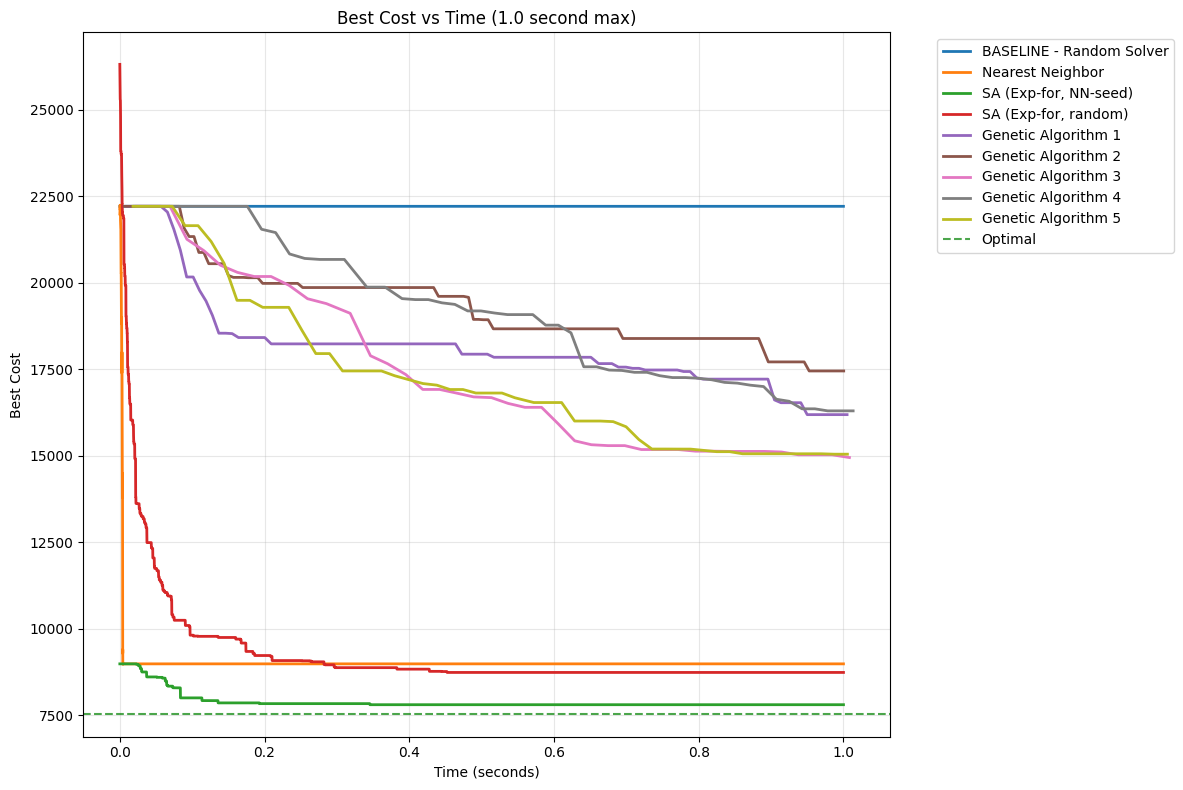

In [8]:
# Plot: Best Cost vs Time
plt.figure(figsize=(12, 8))
for original_name, data in time_results.items():
    short_name = short_names_mapping[original_name]
    plt.plot(data['times'], data['best_costs'], label=short_name, linewidth=2)
if optimal_cost is not None:
    plt.axhline(y=optimal_cost, color='green', linestyle='--', alpha=0.7, label='Optimal')
plt.xlabel('Time (seconds)')
plt.ylabel('Best Cost')
plt.title(f'Best Cost vs Time ({MAX_SECONDS} second max)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

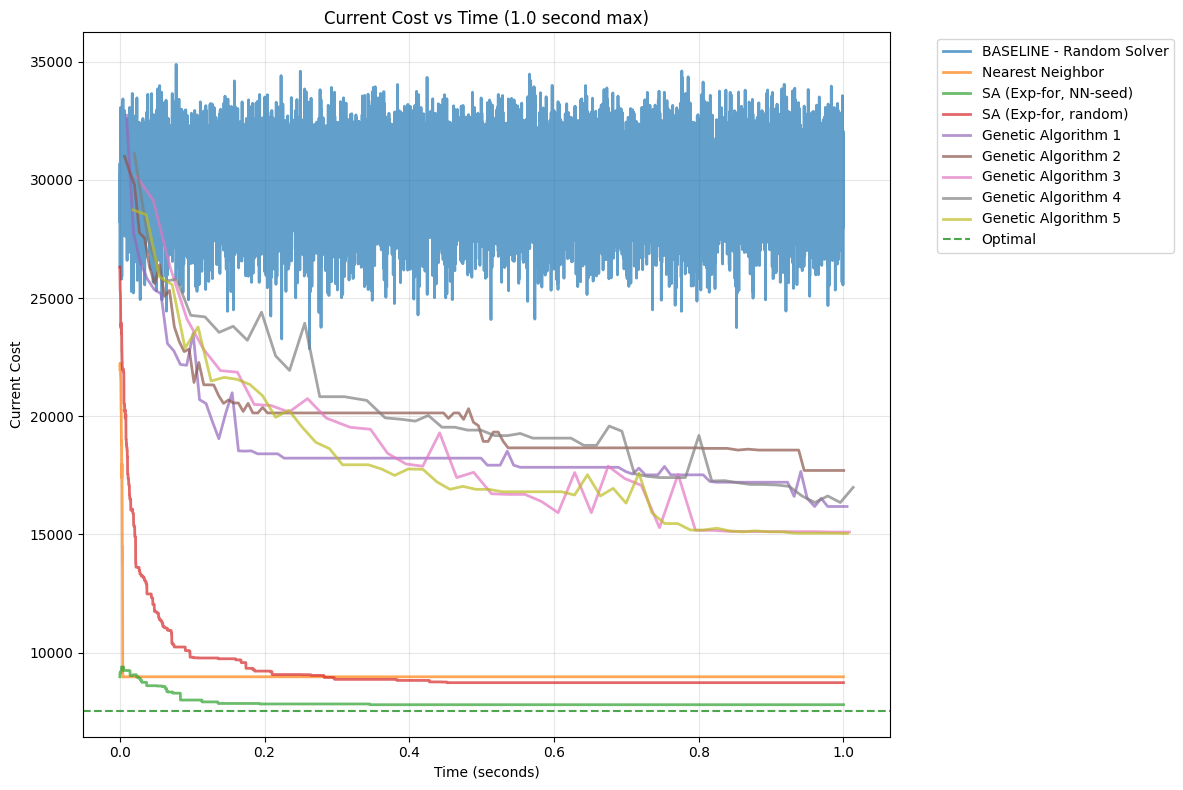

In [9]:
# Plot: Current Cost vs Time
plt.figure(figsize=(12, 8))
for original_name, data in time_results.items():
    short_name = short_names_mapping[original_name]
    plt.plot(data['times'], data['current_costs'], label=short_name, linewidth=2, alpha=0.7)
if optimal_cost is not None:
    plt.axhline(y=optimal_cost, color='green', linestyle='--', alpha=0.7, label='Optimal')
plt.xlabel('Time (seconds)')
plt.ylabel('Current Cost')
plt.title(f'Current Cost vs Time ({MAX_SECONDS} second max)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

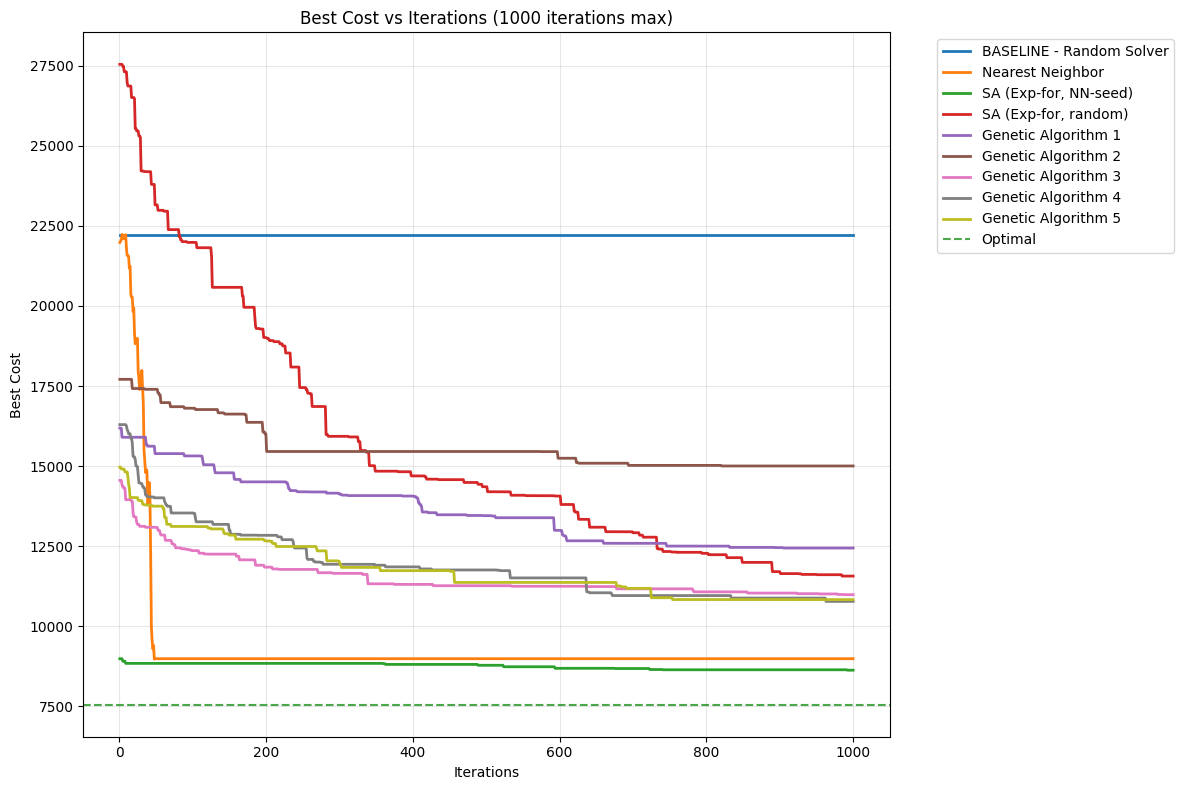

In [10]:
# Plot: Best Cost vs Iterations
plt.figure(figsize=(12, 8))
for original_name, data in iteration_results.items():
    short_name = short_names_mapping[original_name]
    plt.plot(data['iterations'], data['best_costs'], label=short_name, linewidth=2)
if optimal_cost is not None:
    plt.axhline(y=optimal_cost, color='green', linestyle='--', alpha=0.7, label='Optimal')
plt.xlabel('Iterations')
plt.ylabel('Best Cost')
plt.title(f'Best Cost vs Iterations ({MAX_ITERATIONS} iterations max)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

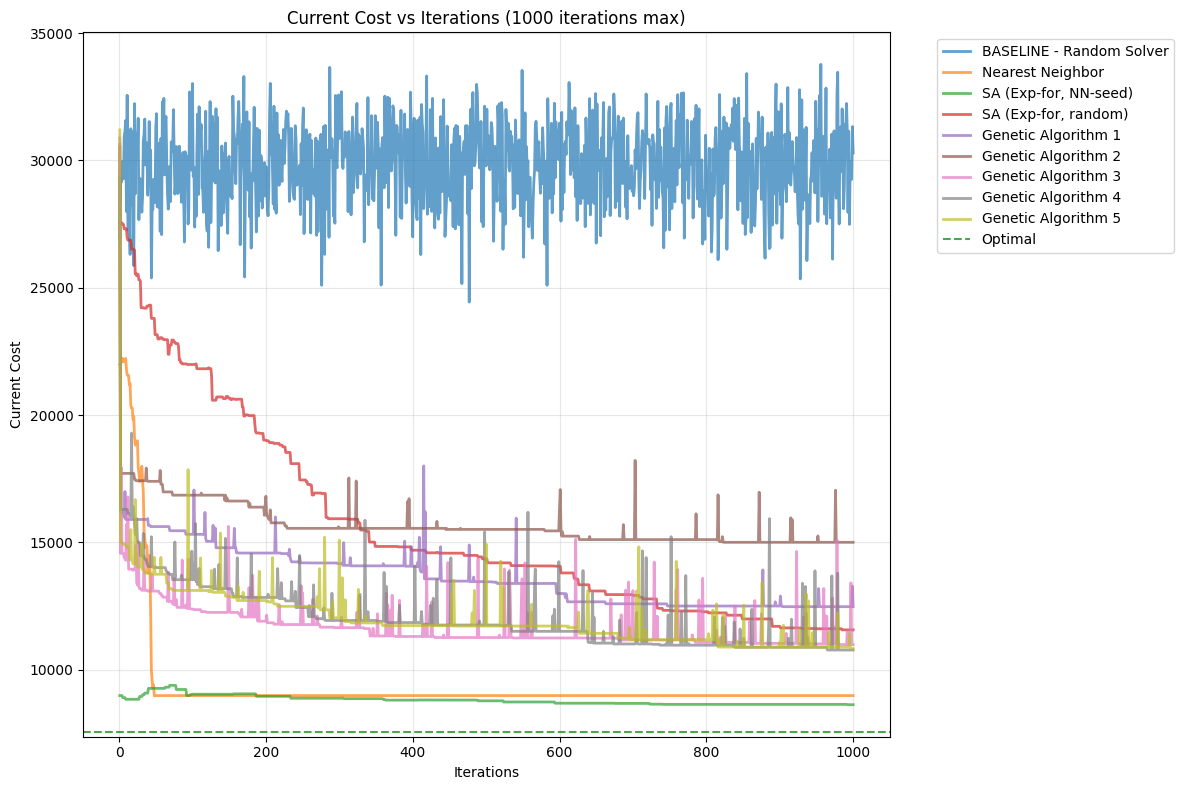

In [11]:
# Plot: Current Cost vs Iterations
plt.figure(figsize=(12, 8))
for original_name, data in iteration_results.items():
    short_name = short_names_mapping[original_name]
    plt.plot(data['iterations'], data['current_costs'], label=short_name, linewidth=2, alpha=0.7)
if optimal_cost is not None:
    plt.axhline(y=optimal_cost, color='green', linestyle='--', alpha=0.7, label='Optimal')
plt.xlabel('Iterations')
plt.ylabel('Current Cost')
plt.title(f'Current Cost vs Iterations ({MAX_ITERATIONS} iterations max)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

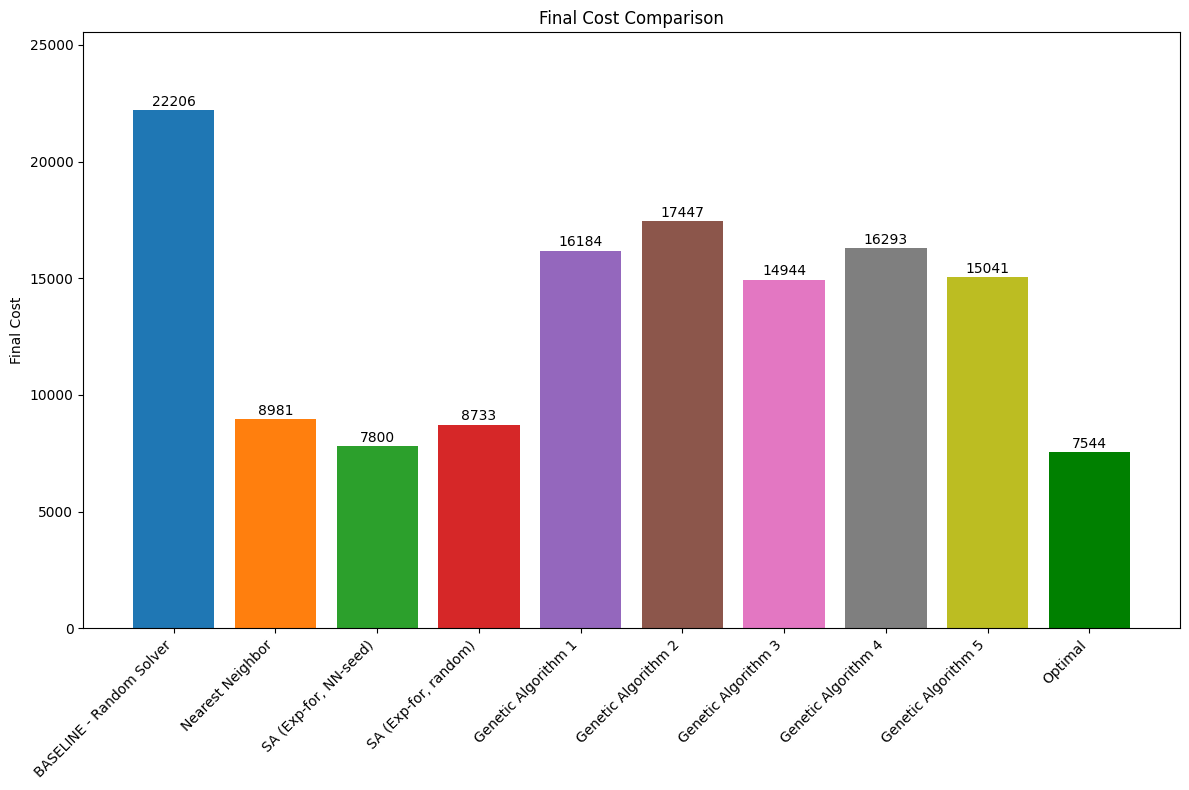

In [12]:
# Plot: Final Cost Comparison
plt.figure(figsize=(12, 8))
original_names = list(time_results.keys())
short_names = [short_names_mapping[name] for name in original_names]
final_costs = [time_results[name]['final_cost'] for name in original_names]

colors = plt.cm.tab10(range(len(short_names)))
if optimal_cost is not None:
    short_names.append('Optimal')
    final_costs.append(optimal_cost)
    colors = list(colors) + ['green']

bars = plt.bar(short_names, final_costs, color=colors)
plt.ylabel('Final Cost')
plt.title('Final Cost Comparison')
plt.xticks(rotation=45, ha='right')

for bar, cost in zip(bars, final_costs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{cost:.0f}', ha='center', va='bottom')

y_max = max(final_costs)
plt.ylim(0, y_max * 1.15)
plt.tight_layout()
plt.show()

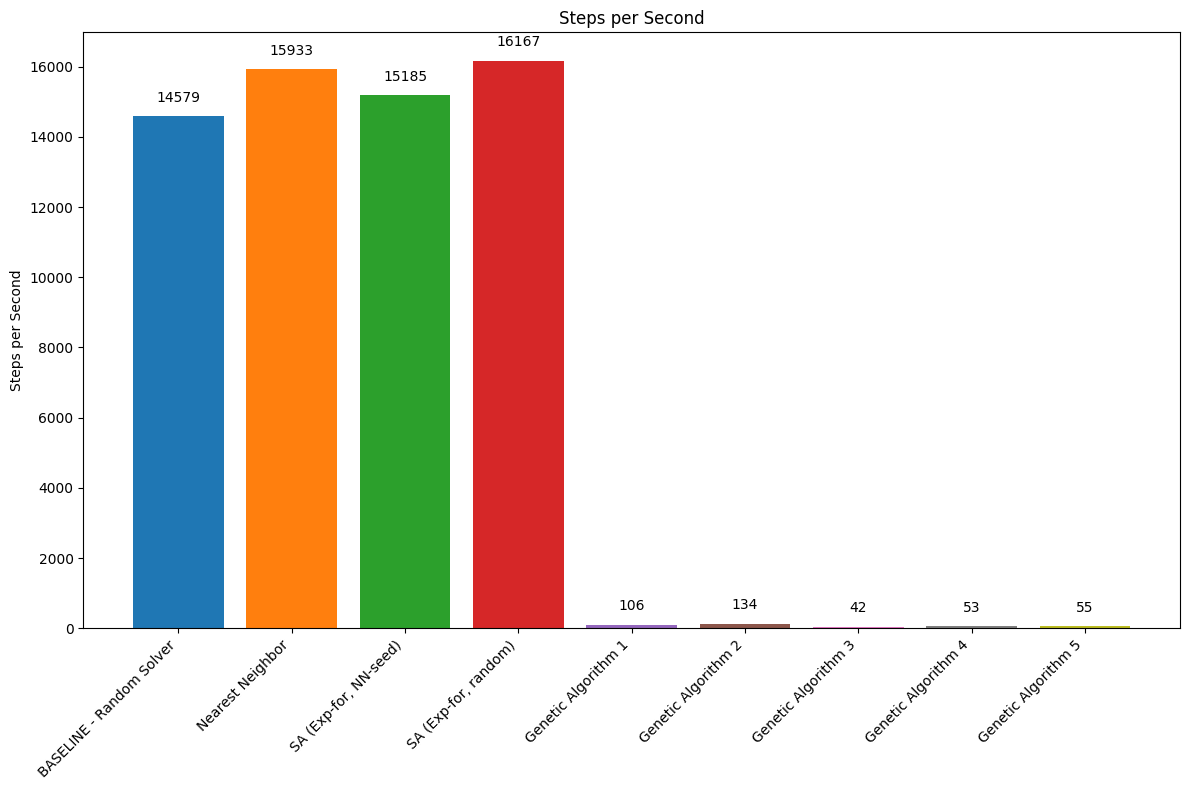

In [13]:
# Plot: Steps per Second
plt.figure(figsize=(12, 8))
original_names = list(time_results.keys())
short_names = [short_names_mapping[name] for name in original_names]
steps_per_second = [time_results[name]['total_iterations'] / MAX_SECONDS for name in original_names]

colors = plt.cm.tab10(range(len(short_names)))
bars = plt.bar(short_names, steps_per_second, color=colors)
plt.ylabel('Steps per Second')
plt.title('Steps per Second')
plt.xticks(rotation=45, ha='right')

for bar, rate in zip(bars, steps_per_second):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(steps_per_second)*0.02, 
            f'{rate:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [14]:
# Summary Statistics
print(f"Final costs near iteration {MAX_ITERATIONS}:")
for name, data in iteration_results.items():
    iterations = data['iterations']
    best_costs = data['best_costs']
    if not iterations:
        continue
    closest_idx = min(range(len(iterations)), key=lambda i: abs(iterations[i] - 50000))
    final_cost = best_costs[closest_idx]
    final_iter = iterations[closest_idx]
    print(f"{name}: {final_cost:.2f} (at iteration {final_iter})")


Final costs near iteration 1000:
BASELINE - Random Solver: 22205.62 (at iteration 1000)
Nearest Neighbor: 8980.92 (at iteration 1000)
SA (Exp-for, NN-seed): 8622.77 (at iteration 1000)
SA (Exp-for, random): 11562.01 (at iteration 1000)
Genetic Algorithm (Pop:44, Mut:0.023, Cros:0.610, Par:24.0, Child:46.0): 12438.06 (at iteration 1000)
Genetic Algorithm (Pop:33, Mut:0.019, Cros:0.628, Par:24.0, Child:43.0): 15002.02 (at iteration 1000)
Genetic Algorithm (Pop:65, Mut:0.077, Cros:0.670, Par:18.0, Child:25.0): 10980.98 (at iteration 1000)
Genetic Algorithm (Pop:61, Mut:0.059, Cros:0.781, Par:19.0, Child:33.0): 10771.23 (at iteration 1000)
Genetic Algorithm (Pop:58, Mut:0.063, Cros:0.768, Par:16.0, Child:28.0): 10826.68 (at iteration 1000)


## Try With a Larger Number of Iterations

In [15]:
MAX_ITERATIONS = 50_000 # INCREASED!
# Run algorithms for iteration-based benchmark
iteration_results = {}
for name, (solver, init_route) in algorithms.items():
    print(f"Running {name} for {MAX_ITERATIONS} iterations...")
    iterations, best_costs, current_costs, times = run_algorithm_with_iterations(instance, solver, init_route, MAX_ITERATIONS)
    iteration_results[name] = {
        'iterations': iterations,
        'best_costs': best_costs,
        'current_costs': current_costs,
        'times': times,
        'final_cost': best_costs[-1] if best_costs else float('inf'),
        'total_time': times[-1] if times else 0
    }
    print(f"  Final cost: {iteration_results[name]['final_cost']:.2f}")
    print(f"  Total time: {iteration_results[name]['total_time']:.3f} seconds")


Running BASELINE - Random Solver for 50000 iterations...
  Final cost: 22205.62
  Total time: 3.529 seconds
Running Nearest Neighbor for 50000 iterations...
  Final cost: 8980.92
  Total time: 2.908 seconds
Running SA (Exp-for, NN-seed) for 50000 iterations...
  Final cost: 8036.14
  Total time: 3.046 seconds
Running SA (Exp-for, random) for 50000 iterations...
  Final cost: 8116.93
  Total time: 3.026 seconds
Running Genetic Algorithm (Pop:44, Mut:0.023, Cros:0.610, Par:24.0, Child:46.0) for 50000 iterations...
  Final cost: 9642.71
  Total time: 452.058 seconds
Running Genetic Algorithm (Pop:33, Mut:0.019, Cros:0.628, Par:24.0, Child:43.0) for 50000 iterations...
  Final cost: 9918.64
  Total time: 337.941 seconds
Running Genetic Algorithm (Pop:65, Mut:0.077, Cros:0.670, Par:18.0, Child:25.0) for 50000 iterations...
  Final cost: 10866.63
  Total time: 1170.302 seconds
Running Genetic Algorithm (Pop:61, Mut:0.059, Cros:0.781, Par:19.0, Child:33.0) for 50000 iterations...
  Final cost

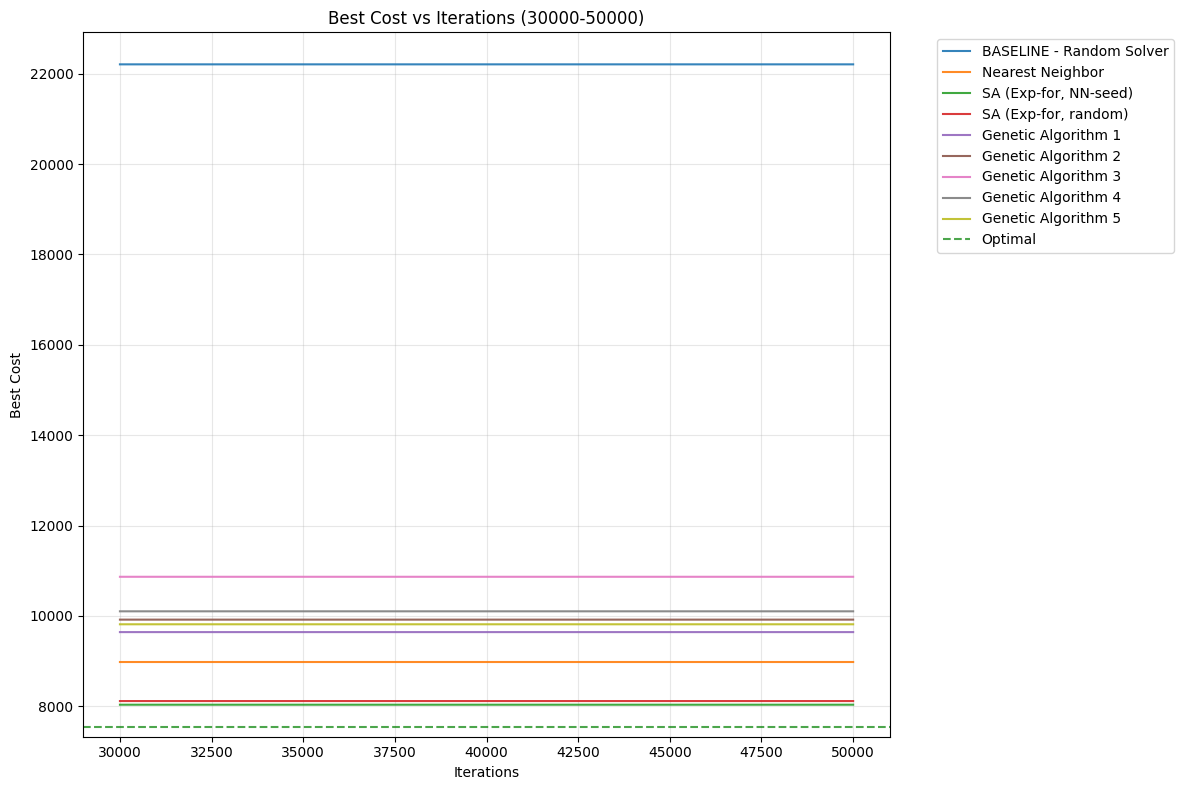

In [16]:
# Plot: Detailed Best Cost (30000-50000 iterations)
plt.figure(figsize=(12, 8))
for original_name, data in iteration_results.items():
    short_name = short_names_mapping[original_name]
    iterations = data['iterations']
    best_costs = data['best_costs']

    filtered_iterations = []
    filtered_costs = []
    for iter_num, cost in zip(iterations, best_costs):
        if 30000 <= iter_num <= 50000:
            filtered_iterations.append(iter_num)
            filtered_costs.append(cost)

    if filtered_iterations:
        plt.plot(filtered_iterations, filtered_costs, label=short_name, linewidth=1.5, alpha=0.9)

if optimal_cost is not None:
    plt.axhline(y=optimal_cost, color='green', linestyle='--', alpha=0.7, label='Optimal')

plt.xlabel('Iterations')
plt.ylabel('Best Cost')
plt.title('Best Cost vs Iterations (30000-50000)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

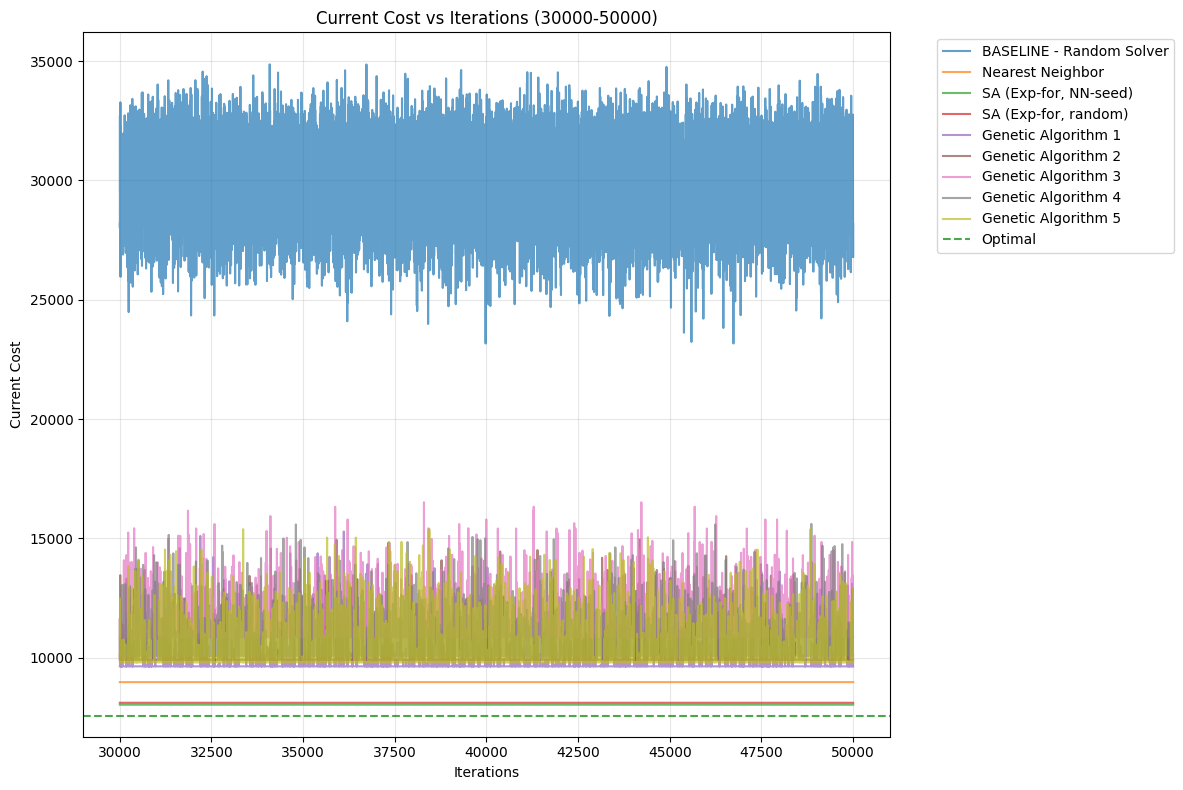

In [17]:
# Plot: Detailed Current Cost (30000-50000 iterations)
plt.figure(figsize=(12, 8))
for original_name, data in iteration_results.items():
    short_name = short_names_mapping[original_name]
    iterations = data['iterations']
    current_costs = data['current_costs']

    filtered_iterations = []
    filtered_costs = []
    for iter_num, cost in zip(iterations, current_costs):
        if 30000 <= iter_num <= 50000:
            filtered_iterations.append(iter_num)
            filtered_costs.append(cost)

    if filtered_iterations:
        plt.plot(filtered_iterations, filtered_costs, label=short_name, linewidth=1.5, alpha=0.7)

if optimal_cost is not None:
    plt.axhline(y=optimal_cost, color='green', linestyle='--', alpha=0.7, label='Optimal')

plt.xlabel('Iterations')
plt.ylabel('Current Cost')
plt.title('Current Cost vs Iterations (30000-50000)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# Summary Statistics
print(f"Final costs near iteration {MAX_ITERATIONS}:")
for name, data in iteration_results.items():
    iterations = data['iterations']
    best_costs = data['best_costs']
    if not iterations:
        continue
    closest_idx = min(range(len(iterations)), key=lambda i: abs(iterations[i] - 50000))
    final_cost = best_costs[closest_idx]
    final_iter = iterations[closest_idx]
    print(f"{name}: {final_cost:.2f} (at iteration {final_iter})")


Final costs near iteration 50000:
BASELINE - Random Solver: 22205.62 (at iteration 50000)
Nearest Neighbor: 8980.92 (at iteration 50000)
SA (Exp-for, NN-seed): 8036.14 (at iteration 50000)
SA (Exp-for, random): 8116.93 (at iteration 50000)
Genetic Algorithm (Pop:44, Mut:0.023, Cros:0.610, Par:24.0, Child:46.0): 9642.71 (at iteration 50000)
Genetic Algorithm (Pop:33, Mut:0.019, Cros:0.628, Par:24.0, Child:43.0): 9918.64 (at iteration 50000)
Genetic Algorithm (Pop:65, Mut:0.077, Cros:0.670, Par:18.0, Child:25.0): 10866.63 (at iteration 50000)
Genetic Algorithm (Pop:61, Mut:0.059, Cros:0.781, Par:19.0, Child:33.0): 10102.63 (at iteration 50000)
Genetic Algorithm (Pop:58, Mut:0.063, Cros:0.768, Par:16.0, Child:28.0): 9815.62 (at iteration 50000)
